<a href="https://colab.research.google.com/github/lauraluebbert/single-cell-studies-over-time/blob/main/single_cell_studies_over_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook generates plots showing the increase in single cell studies over time. 

Data source (please cite):   
Valentine Svensson, Eduardo da Veiga Beltrame, & Lior Pachter
Database, Volume 2020, 2020, baaa073; doi: 10.1093/database/baaa073

Also see:  
https://www.nxn.se/single-cell-studies  
https://www.nxn.se/single-cell-studies/gui  

Code partly adapted from:  
https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/docs/tutorials/scRNA-seq_intro/python/scRNA-seq_intro.ipynb

___

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mplcol
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

from datetime import datetime

import colorsys
import plotnine as p
from mizani.breaks import date_breaks
from mizani.formatters import date_format

%config InlineBackend.figure_format = "retina"

Load data:

In [2]:
df = pd.read_csv("http://nxn.se/single-cell-studies/data.tsv", sep="\t")
# Convert date string to date format
df["Date"] = pd.to_datetime(df["Date"], format="%Y%m%d")
# Convert string of reported cells total to float
df["Reported cells total"] = df["Reported cells total"].str.replace(",", "").map(float)

In [3]:
# Make folder to save the plots in
!mkdir plots

Plot number of studies over time:

In [4]:
fontsize = 12

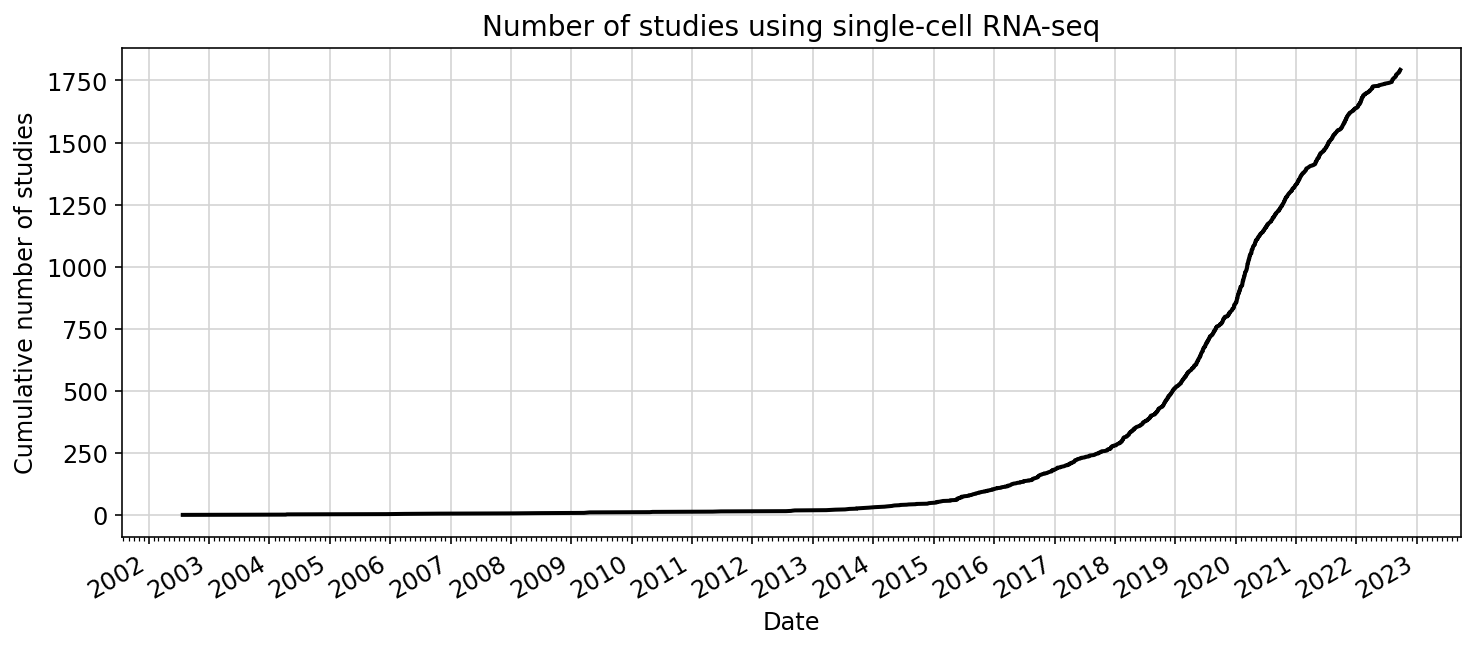

In [5]:
fig, ax = plt.subplots(figsize=(12, 5))

# Get counts per date
df = df.sort_values("Date")
df["count"] = 1
x = df.Date
y = df["count"].groupby(df.Date.dt.time).cumsum()

ax.plot(x, y, lw=2, color="k")
ax.set_title("Number of studies using single-cell RNA-seq", fontsize=fontsize+2)
ax.set_xlabel("Date", fontsize=fontsize)
ax.set_ylabel("Cumulative number of studies", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)

# Format the x ticks
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator() # every month
yearsFmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
fig.autofmt_xdate()

# Add grid and set below graph
ax.grid(True, which="major", color="lightgray")
ax.set_axisbelow(True)

plt.savefig("./plots/studies_over_time.png", bbox_inches='tight', dpi=300)

fig.show()

Plot number of cells sequenced over time:

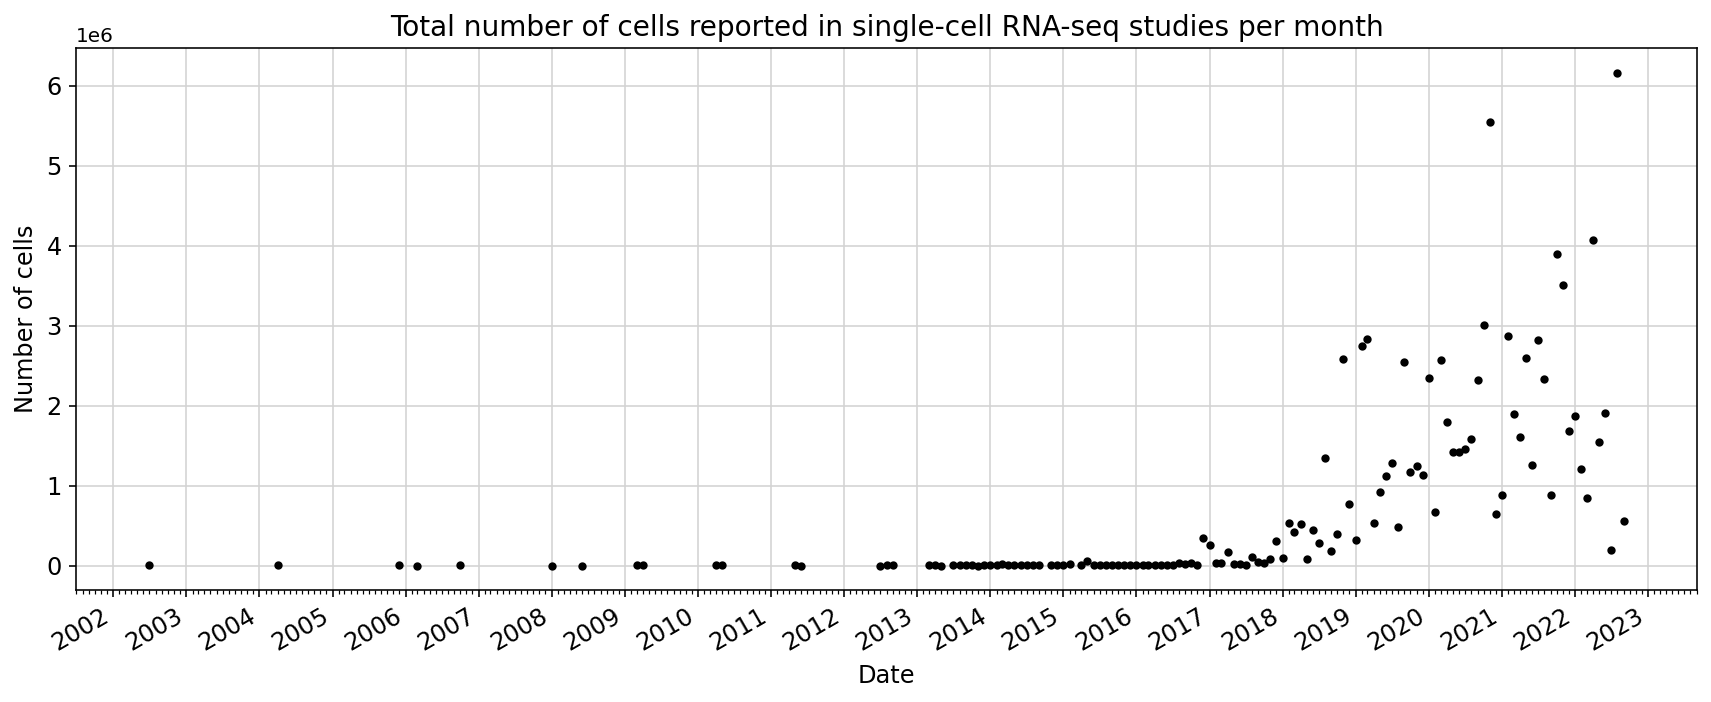

In [6]:
fig, ax = plt.subplots(figsize=(12, 5))

# Get total cell counts per month per year
per_month_year = df.Date.dt.to_period("M")
x = df.groupby(per_month_year).sum().index.to_timestamp()
y = df.groupby(per_month_year).sum()["Reported cells total"].values

ax.scatter(x, y, s=10, color="k")
ax.set_title("Total number of cells reported in single-cell RNA-seq studies per month", fontsize=fontsize+2)
ax.set_xlabel("Date", fontsize=fontsize)
ax.set_ylabel("Number of cells", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)

# Format the x ticks
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator() # every month
yearsFmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
fig.autofmt_xdate()

# Add grid and set below graph
ax.grid(True, which="major", color="lightgray")
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig("./plots/cells_over_time.png", bbox_inches='tight', dpi=300)

fig.show()

Plot technologies used over time:

<Figure size 432x288 with 0 Axes>

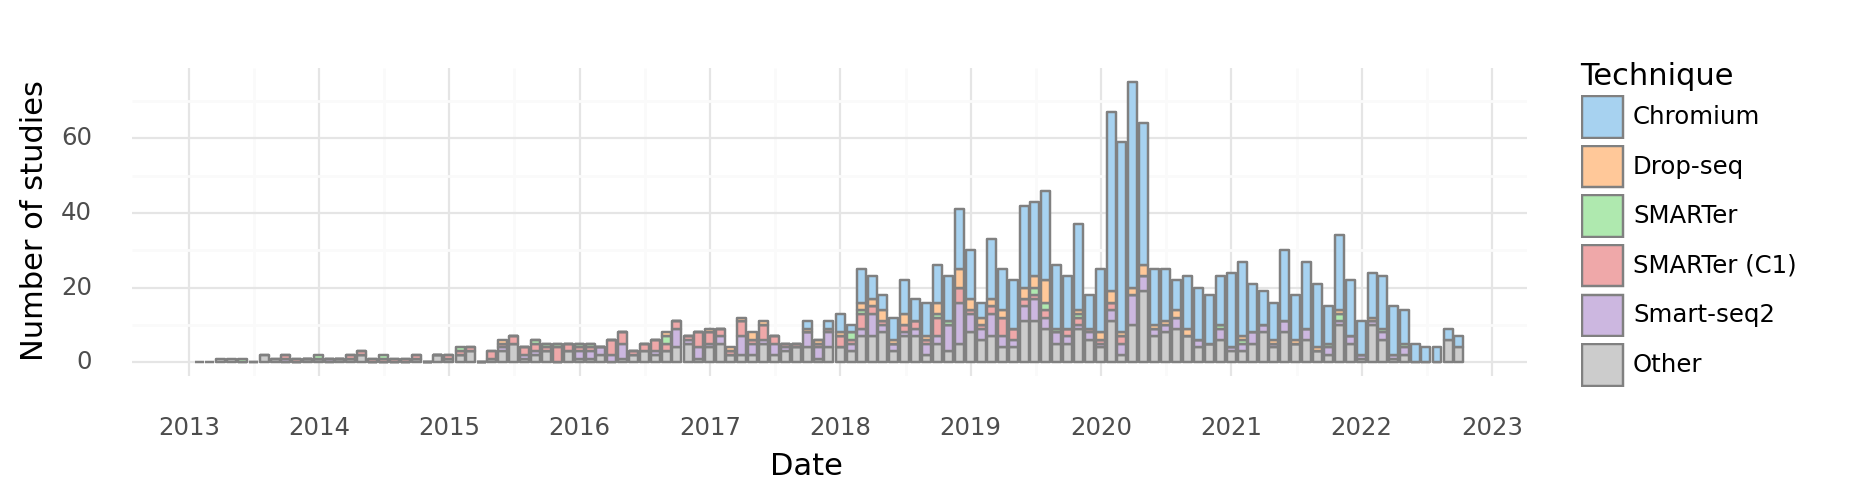

<ggplot: (8754589991723)>

In [7]:
def tidy_split(df, column, sep='|', keep=False):

    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    
    return new_df

ts = pd.Timestamp

tdf = tidy_split(df, 'Technique', ' & ')
t_dict = {k: k for k in tdf['Technique'].value_counts().head(5).index}
tdf['Technique'] = tdf['Technique'].map(lambda s: t_dict.get(s, 'Other'))
techs = list(
    tdf['Technique']
    .value_counts()
    .sort_index()
    .index
    .difference(['Other'])
)
techs.append('Other')
tdf['Technique'] = (
    pd.Categorical(
       tdf['Technique'],
        categories=techs,
        ordered=True
    )
)

def desaturate(color, prop):
    
    # Check inputs
#     if not 0 <= prop <= 1:
#         raise ValueError("prop must be between 0 and 1")

    # Get rgb tuple rep
    rgb = mplcol.colorConverter.to_rgb(color)

    # Convert to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)

    # Desaturate the saturation channel
#     l *= prop
    l = 0.8

    # Convert back to rgb
    new_color = colorsys.hls_to_rgb(h, l, s)
    
    hex_color = '#{:02x}{:02x}{:02x}'.format(*map(lambda c: int(c * 255), new_color))

    return hex_color

    # lighten matplotlib default colors
clrs = list(map(lambda c: desaturate(c, 1.2), ['C0', 'C1', 'C2', 'C3', 'C4', 'black']))

#### Plot number of studies per month by technique
per_month = (
    tdf
    .groupby('Technique')
    .resample('1M', on='Date')
    .count()['DOI']
    .reset_index()
)

p.options.figure_size = (9, 2)
fig = (
    p.ggplot(
        p.aes(x='Date', y='DOI', fill='Technique'),
        data=per_month.query('Date > @ts("20130101T010101")')
    )
    + p.geom_bar(stat='identity', color='grey')
    + p.theme_minimal(base_family='DejaVu Sans')
    + p.scale_x_datetime(
        breaks=date_breaks('1 years'),
        labels=date_format('%Y')
    )
    + p.labs(y='Number of studies')
    + p.scale_fill_manual(clrs)
)

fig